# 线段绘制

> 本章节算法和代码引用了 Dmitry V. Sokolov 的 [tinyrenderer](https://github.com/ssloy/tinyrenderer) 第一章线段光栅化过程。在原算法的基础上，本章节做了整理、改进和重构。感谢 Dmitry V. Sokolov 将这一段算法整理成册，并开源地发布在 GitHub 供所有人使用。

在上一单元，我们了解了颜色的表示方式，基础颜色的绘制，以及基础的着色过程。对于着色过程，我们还引入了现代GPU的着色器的概念，并简单地描述了像素着色器。在这一章，我们将通过代码绘制最基础的几何图形，线段，的绘制。

在数学上，线段由两个端点和端点的连线构成。对于任何一个线段，我们可以通过线段的方程$f(x)=ax+b$来进行描述，或者我们也可以通过线段的一个端点，线段的方向，以及线段的长度来描述一个线段。

假设存在一根线段，其端点为$(x_1,y_1)$，$(x_2,y_2)$，我们试着找出所有在该线段上的点。

我们设向量$\vec{L}=(x_2,y_2)-(x_1,y_1)$，那么很显然，线段上的点满足参数方程

$$
y = \vec{L}*t + (x_1,y_1)
$$

其中，`t`的取值范围为`[0,1]`。

现在让我们结合 Python 代码，在屏幕空间上绘制绘制一根红色的，端点为`(0.2,0.2)`和`(0.6,0.6)`的线段。

## 线段的参数方程绘制

首先要说明的是我们的坐标系，由于 Python 中图片的特殊性，左上角为坐标原点，右下角为坐标的`(1,1)`点，我们为了更好地贴合数学上的笛卡尔坐标系，我们将图片上下翻转，使得做左下角为原点，右上角为`(1,1)`点。

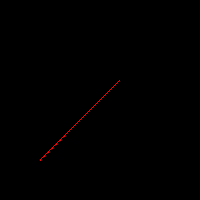

In [1]:
from PIL import Image

def draw_line(img, p1, p2, step, color):
    lx, ly = p2[0] - p1[0], p2[1] - p1[1]
    t = 0
    while t <= 1:
        x, y = p1[0] + t * lx, p1[1] + t * ly
        coord = (int(img.size[0] * x), int(img.size[1] * (1-y)))
        img.putpixel(coord, color)
        t += step

w, h = 200, 200
img = Image.new('RGBA', (w, h), 'black')
draw_line(img, (0.2, 0.2), (0.6, 0.6), 0.01, (255, 0, 0, 255))
display(img)

我们观察到`while t <= 1: t += step`这一层循环。由于计算机只能表示离散地数列，而无法表示连续的取值范围，我们只能通过一个极小数，0.01，的步进来拟合连续的表达。如果我们把这一个步进的步长取得过小，则会大幅度增加计算机的计算负担，实际上，当步长过小时，而我们整张图片的大小却只有 200x200 像素，这就意味着，每一小步增长甚至没有超出一个像素，那么有大量的像素被重新计算和重新着色。

如果我们将步长取得过大，那么线段则会发生断裂的现象。

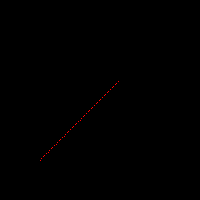

In [2]:
w, h = 200, 200
img = Image.new('RGBA', (w, h), 'black')
draw_line(img, (0.2, 0.2), (0.6, 0.6), 0.02, (255, 0, 0, 255))
display(img)

很显然，对于这个算法，我们必须精确控制参数`t`的取值，才能得到完整的，同时又不过多绘制的线段。

## 像素空间绘制

我们首先尝试解决第一个问题，如何避免参数`t`的取值影响我们最后的呈现效果。

从数学的角度出发，`t`的取值越小，我们获得的结果一定越精确，当我们用微分$dt$作为变化的时候，我们则可获得完整的连续的线段。另一方面，将数学定义的世界空间的线段转换成我们的图片的时候，最终的线段只会用有限个像素表达。由于线段是连续的，那么在其两个端点间，$[x_1,x_2]$，每一个`x`一定有一个`y`相对应。而在像素层面上来说，`x`的取值个数是有限的，因此我们可以用如下方式绘制：

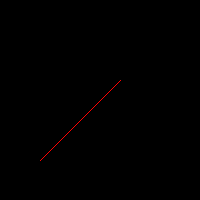

In [3]:
def draw_line(img, p1, p2, color):
    px1, px2 = int(p1[0] * img.size[0]), int(p2[0] * img.size[0])
    py1, py2 = int(p1[1] * img.size[1]), int(p2[1] * img.size[1])
    x = px1
    while x <= px2:
        t = (x - px1) / (px2 - px1)
        y = img.size[1] - int(t * (py2 - py1) + py1)
        img.putpixel((x, y), color)
        x += 1

w, h = 200, 200
img = Image.new('RGBA', (w, h), 'black')
draw_line(img, (0.2, 0.2), (0.6, 0.6), (255, 0, 0, 255))
display(img)

在像素空间进行计算和绘制，我们确保了取值范围内的横向的每一个`x`都有一个`y`与之相对应。并且更重要的是，这意味着线段在横轴上的投影一定是连续的。然而，线段在纵轴上的投影却并非如此。

当前，线段的斜率为 1，我们试着绘制两根额外的线段，绿色的线段斜率小于 1，蓝色的线段斜率大于 1。

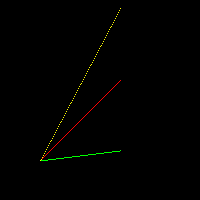

In [4]:
w, h = 200, 200
img = Image.new('RGBA', (w, h), 'black')
draw_line(img, (0.2, 0.2), (0.6, 0.6), (255, 0, 0, 255))
draw_line(img, (0.2, 0.2), (0.6, 0.25), (0, 255, 0, 255))
draw_line(img, (0.2, 0.2), (0.6, 0.96), (255, 255, 0, 255))
display(img)

我们可以发现，红色和绿色的线段可以被连续的绘制，然而黄色的线段却出现了明显的断点。这是因为当斜率大于 1 时，线段的横轴的投影是连续的，然而线段的纵轴的投影却不连续。从像素层面解释，高度的像素的个数大于宽度的像素个数，如果我们还是依旧宽度进行采样，显然不能覆盖所有的高度像素。一个简单的解决方案是，当斜率大于 1 时，以高度作为循环进行采样，当斜率小于 1 时，以宽度作为循环进行采样。

## Bresenham 直线算法

经过我们上一轮的改进，我们已经能够绘制基本的线段。但是我们的算法还有没有改进的余地，让绘制的效率变得更高呢？

首先我们观察循环中的两次运算

```python
t = (x - px1) / (px2 - px1)
y = img.size[1] - int(t * (py2 - py1) + py1)
```

当我们求系数`t`的时候，用到了浮点除法，而大量的浮点运算无疑会降低绘制的效率。将浮点运算转换成整数运算，将除法运算转换成加法和减法运算能有效提高绘制效率。

这里我们将介绍著名的 Bresenham 直线算法。Bresenham 直线绘制算法由 Jack Elton Bresenham 于 1962 年在 IBM 工作时发明。由于算法简单易懂，并且绘制效率高效成为线段绘制的标准算法。

我们再来回顾一下线段的绘制过程。

我们从线段的一个端点出发，假使线段斜率小于等于 1，且用横坐标扫描的方式进行绘制（对于斜率大于 1 的线段，我们可以通过纵坐标扫描的形式进行。由于算法是对称的，这里假定横坐标扫描），对于线段两个端点中的每一个`x`，都可以计算出一个`y`坐标。**由于线段的斜率小于等于 1，任意两个相邻的`x`，其对应的`y`要么相等，要么相差 1**。

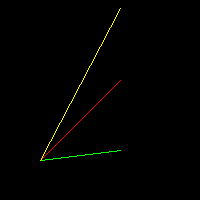

In [5]:
def draw_line(img, p1, p2, color):
    # 将屏幕坐标转换到像素空间
    p1i = (int(p1[0] * img.size[0]), int(p1[1] * img.size[1]))
    p2i = (int(p2[0] * img.size[0]), int(p2[1] * img.size[1]))
    
    # 如果斜率大于1，我们将x和y交换，从而统一为横扫描
    steep = False
    if abs(p1i[0] - p2i[0]) < abs(p1i[1] - p2i[1]):
        p1i = (p1i[1], p1i[0])
        p2i = (p2i[1], p2i[0])
        steep = True
    
    # 如果p1点在p2点的右侧，则交换两点，从而统一为从左到右扫描
    if p1i[0] > p2i[0]:
        p1i, p2i = p2i, p1i
    
    dx = p2i[0] - p1i[0]
    dy = p2i[1] - p1i[1]
    derror = abs(dy / dx)
    error = 0
    y = p1i[1]
    for x in range(p1i[0], p2i[0]+1):
        if steep:
            img.putpixel((y, img.size[1]-x), color)
        else:
            img.putpixel((x, img.size[1]-y), color)
        # 当x步进一格，累积一次error，如果error超过0.5，意味着y需要步进一格
        error += derror
        if error > 0.5:
            # 如果斜率为正，则向上步进，否则向下步进
            y += 1 if p2i[1] > p1i[1] else -1
            # error-1，重置一个像素偏移，重新计算累积error
            error -= 1

w, h = 200, 200
img = Image.new('RGBA', (w, h), 'black')
draw_line(img, (0.2, 0.2), (0.6, 0.6), (255, 0, 0, 255))
draw_line(img, (0.2, 0.2), (0.6, 0.25), (0, 255, 0, 255))
draw_line(img, (0.2, 0.2), (0.6, 0.96), (255, 255, 0, 255))
display(img)

运行上述程序，我们得到完美的线段渲染。